# $$\textbf{Binary phase evaluation}$$

We model a binary system embedded in an accretion disk, along with a dark matter spike and gravitational waves emission.
The goal for our modelization is to produce an estimate of the following quantity: 

\begin{equation}
    \dot{r} = \dot{r}_{\mathrm{gas}} + \dot{r}_{\mathrm{DF}} + \dot{r}_{\mathrm{GW}}\text{,}
\end{equation}

where $\dot{r}_\mathrm{gas}$ is the contribution coming from gas torques from the accretion disk surrounding the binary, $\dot{r}_\mathrm{DF}$ is the effect of dynamical friction from the presence of the dark matter spike, and $\dot{r}_\mathrm{GW}$ is the contribution from the gravitational waves emission. Specifically, we adopt the classical Newtonian formalism, computing the results from the reduced mass-system, and in case assuming that $m_1 \gg m_2$.

Once the shape of $\dot{r}$ is clear, one can evaluate the phase of the binary system from a generic $f$-frequency to the $f_{\mathrm{isco}}$-frequency. Assuming circular orbits the frequency is:

\begin{equation}
    f = \frac{1}{\pi} \sqrt{\frac{G(m_1 + m_2)}{r^3}}\text{.}
\end{equation}

We can evaluate $\Phi(f)$ as: 

\begin{equation}
    \Phi(f) = 2\pi \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{df'} f' df'\text{,}
\end{equation}

where the relation $\frac{dt}{df'}$ is extracted directly from the expression in the above equation by the following chain rule: $\frac{dr}{dt} \frac{df}{dr} = \frac{df}{dt}$. 

### Note!

If we already integrate on the grid that starts from $\textit{isco}$ we are subtracting the $\Phi(f_{\mathrm{isco}}) = \int_{f_{\mathrm{isco}}}^{f_{\mathrm{isco}}} \frac{dt}{df} f' df' = 0$ to the phase $\Phi(f)$.

## Expressions for the $\dot{r}_i$ contributions

- Accretion disk's torques: 

\begin{equation}
    \dot{r}_\mathrm{gas} = - 2 \Sigma_0 \frac{r^{\gamma + 3/2}}{r_0^\gamma} \frac{G^{1/2} (m_1 + m_2)^{1/2}}{\mu} q^{2} \mathcal{M}^2\text{.}
\end{equation}

- Dark matter spike's dynamical friction:

Static:

\begin{equation}
\label{eq:r_dot_DF}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}}\text{,}
\end{equation}

- Gravitational waves: 

\begin{equation}
\label{eq:r_dot_gw}
    \dot{r}_{\mathrm{GW}} = - \frac{64 (m_1 + m_2) G^3 m_1 m_2}{5 c^5 r^3}\text{.}
\end{equation}

In the code, there will be enabled the possibility to choose which of these options to keep in the final formula, which will account for the sum of all the contributions the user requires. 

## Formulas to use and implement "in code" for the phase evaluation

I used the following quantities: 

- Derivative of f in radial separation:

\begin{equation}
\label{eq:dfdr}
    \frac{df}{dr} = \frac{1}{\pi} (-\frac{3}{2}) \sqrt{\frac{G (m_1 + m_2)}{r^5}}\text{.}\\
\end{equation}


- Inverse of f(r):

\begin{equation}
\label{eq:r(f)}
    r(f) = \sqrt[3]{\frac{G (m_1 + m_2)}{\pi^2 f^2}}\text{,}\\
\end{equation}

- Derivative of f in time:

\begin{equation}
\label{eq:dfdt}
    \frac{df}{dt} = \dot{r} \frac{df}{dr}\text{,}\\
\end{equation}

- Second derivative of the phase in time:

\begin{equation}
\label{eq:phi_dot-dot}
    \ddot{\Phi}(f) = 4 \pi^2 f \left(\frac{d\Phi(f)}{df}\right)^{-1} 
\end{equation}

# Code implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy as sp
from scipy.integrate import quad, simps 
from scipy.special import hyp2f1, betainc
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm

In [2]:
# Define some constants: 

G = 6.67408e-11 # kg^-1 m^3 / s^2
c = 299792458.0 # m / s
pc = 3.08567758149137e16 # m
m_sun = 1.98855e30 # kg

## General functions

Below we find a bunch of functions to perform useful operations throughout the code.

In [3]:
def hypgeom_scipy(a, x):
        '''Compute the hypergeometric function using scipy.'''
        return hyp2f1(1, a, 1 + a, x)

def hyp2f1_derivative(hyp2f1, f):
        '''Finds derivative of the gauss_hypergeom function through differentiation.'''
        delta_function = np.concatenate(([np.min(hyp2f1)], hyp2f1[1:] - hyp2f1[:-1]))
        delta_fs = np.concatenate(([np.max(f)], f[1:] - f[:-1]))
        return delta_function/delta_fs

In [4]:
# From Git code

def get_r_s(m_1, rho_s, gamma_s):
    return ((3 - gamma_s) * 0.2 ** (3 - gamma_s) * m_1 / (2 * np.pi * rho_s)) ** (1 / 3)
    
def get_rho_s(rho_6, m_1, gamma_s):
    a = 0.2
    r_6 = 1e-6 * pc
    m_tilde = ((3 - gamma_s) * a ** (3 - gamma_s)) * m_1 / (2 * np.pi)
    return (rho_6 * r_6 ** gamma_s / (m_tilde ** (gamma_s / 3))) ** (1 / (1 - gamma_s / 3))

def get_rho_6(rho_s, m_1, gamma_s):
    a = 0.2
    r_s = ((3 - gamma_s) * a ** (3 - gamma_s) * m_1 / (2 * np.pi * rho_s)) ** (1 / 3)
    r_6 = 1e-6 * pc
    return rho_s * (r_6 / r_s) ** -gamma_s

def phasePN(nu, v):
        return (3715/1008 + 55 * nu /12) * v**2 - 10 * np.pi * v**3 +(15293365/1016064 + 27145 * nu /1008 + 3085 * nu**2 / 144) * v**4

## Environments 

I below will implement a class for each of the environment of study. This will allow me to compute the different $\dot{r}$ separately, and then use them in a more general function evaluating the phase to coalescence.

### Vacuum binary

In [5]:
class VacuumBinary:
    
    # Define constants
    
    G = 6.67408e-11 # kg^-1 m^3 / s^2
    c = 299792458.0 # m / s
    m_sun = 1.98855e30 # kg
    pc = 3.08567758149137e16 # m
    
    def __init__(self, m1, m2, dist): 
        
        # Binary params:
        self.m1 = m1
        self.m2 = m2
        self.mu = self.m1 * self.m2 / (self.m1 + self.m2)
        self.q = self.m2/self.m1
        self.M_tot = self.m1 + self.m2
        self.dist = dist
        self.chirp_mass = (self.m1 * self.m2)**(3/5) / (self.M_tot)**(1/5)
    
    #---- Basic functions-----    
    
    def frequency(self, r):
        '''Finds the binary frequency assuming circular orbits, at fixed radius r.'''
        return np.sqrt(self.G * self.m1 / r**3) / np.pi 
    
    def radius(self, f):
        '''Finds the binary radius assuming circular orbits, at fixed frequency f.'''
        return (self.G * self.M_tot / (np.pi**2 * f**2))**(1/3)
    
    def df_dr(self, r): 
        '''Finds the binary frequency radial derivative assuming circular orbits.'''
        return -1.5 * np.sqrt(self.G * self.m1 / r**5) / np.pi
    
    #-----Vacuum binary initializer----
    
    def vacuum_phase(self, r):
        '''Analytical vacuum phase solution.'''
        freqs = self.frequency(r)
        r_isco = 6 * self.m1 * self.G / self.c**2
        f_isco = self.frequency(r_isco)
        return -self.G**(-5/3) * (self.M_tot)**(1/3) * self.c**5 / (16 * np.pi**(5/3) * self.m1 * self.m2) * (freqs**(-5/3) - f_isco**(-5/3))
    
    def dvacuum_phase_df(self, r):
        '''Analytical derivation of vacuum phase solution.'''
        freqs = self.frequency(r)
        return -self.G**(-5/3) * (self.M_tot)**(1/3) * self.c**5 / (16 * np.pi**(5/3) * self.m1 * self.m2) * (-5/3) * (freqs**(-5/3-1))
    
    #---Phase to coalescence----
    
    def dot_r_gw(self, r):
        '''Finds the derivative of radial separation in the vacuum case.'''
        return - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)

### Accretion disk

In [6]:
class AccretionDisk:
    
    # Define constants
    
    G = 6.67408e-11 # kg^-1 m^3 / s^2
    c = 299792458.0 # m / s
    m_sun = 1.98855e30 # kg
    pc = 3.08567758149137e16 # m
    
    def __init__(self, m1, m2, dist, mach, sigma0, alpha):
        
        # Accretion Disk params:
        self.mach = mach
        self.r0 = 6 * self.G * m1 / self.c**2 # 3 * r_schwarzschild
        self.sigma0 = sigma0 / self.mach**2
        self.alpha = alpha
        
        # Binary initialization
        self.Binary_init = VacuumBinary(m1 = m1, m2 = m2, dist = dist)
        
    def sigma_acc(self, r): 
        '''Finds the surface density profile of an accretion disk.'''
        return self.sigma0 * (r / self.r0)**(self.alpha)

    def rho_disk(self, r):
        '''Finds the density profile of the disk using \rho \simeq \Sigma(r)/(2h), where h = r / Mach.'''
        h = r / self.mach
        return self.sigma_acc(r) / (2 * h) 
    
    def gas_torque(self, r): 
        '''Finds the gas torque on the secondary.'''
        return - self.sigma_acc(r) * r**4 * np.sqrt(self.G * self.Binary_init.M_tot / r**3) * self.Binary_init.q**2 * self.mach**2
    
    #---Phase to coalescence----
    
    def dot_r_acc(self, r):
        '''Finds the derivative of radial separation within an accretion disk.'''
        r_dot_acc = 0.5 * self.gas_torque(r) * self.Binary_init.m2**(-1) * r**(1/2) * (self.G * self.Binary_init.M_tot)**(-1/2)
        return r_dot_acc

### Dark matter

In [7]:
class DarkMatter():
    
    # Define constants
    
    G = 6.67408e-11 # kg^-1 m^3 / s^2
    c = 299792458.0 # m / s
    m_sun = 1.98855e30 # kg
    pc = 3.08567758149137e16 # m
    
    def __init__(self, m1, m2, dist, q, gammas, rho6, r6, epsv):
    
    # Dark matter spike params:
        self.logL = 1 / np.sqrt(q)
        self.gammas = gammas
        self.rho6 = rho6
        self.r6 = r6
        self.epsv = epsv
        
    # Binary initialization
        self.Binary_init = VacuumBinary(m1 = m1, m2 = m2, dist = dist)
        
    
        
    def rho_dm(self, r):
        '''Finds the density profile of the dark matter using the above formulation.'''
        return self.rho6 * (self.r6 / r)**(self.alpha)
    
    #----Phase to coalescence---
    
    def dot_r_effDM(self, r):
    
        '''Find the dor_r_eff from reversed process from analytical phi_eff(f).'''

        freqs = self.Binary_init.frequency(r)
        df_dr_s = self.Binary_init.df_dr(r)
        
        # Vacuum 
        
        phase_vacuum = self.Binary_init.vacuum_phase(r)
        dphase_vacuum_df = self.Binary_init.dvacuum_phase_df(r)
        
        # Constants
        
        rho_s = get_rho_s(self.rho6, self.Binary_init.m1, self.gammas)
        r_s = get_r_s(self.Binary_init.m1, rho_s, self.gammas)
        
        gamma_e = 5/2 
        theta = 5 / (2 * gamma_e)
        c_f = 5 * self.c**5 / (8 * self.Binary_init.m1**2) * np.pi**(2 * (self.gammas - 4) / 3) * self.G**(- (2 + self.gammas)/3) * self.Binary_init.M_tot**((1 - self.gammas) / 3) * r_s**(self.gammas) * self.epsv * rho_s * self.logL
        f_eq = c_f**(3 / (11 - 2 * self.gammas))
        lambda_ = (11 - 2 * (self.gammas + gamma_e)) / 3
        f_b = 0.8163 * (self.Binary_init.m1 / (1000 * self.m_sun))**(-1.4412) * (self.Binary_init.m2 / self.m_sun)**(0.4511) * (1 - 0.4971 * np.log(self.gammas / 1.4396))
        eta = (5 + 2 * gamma_e) / (2 * (8 - self.gammas)) * (f_eq / f_b)**((11 - 2 * self.gammas) / 3)
        f_t = f_b
        
        # Variables 
    
        y = freqs / f_t
        dy_df = 1 / f_t
        
        # Hypergeometric function
        
        gauss_hypergeom = hyp2f1(1, theta, 1 + theta, - y**(-5/(3 * theta)))
        dgauss_hypergeom_df = hyp2f1_derivative(gauss_hypergeom, freqs)
        
        # Find phase derivative in frequency
        
        exp_y = y**(-lambda_)
        d_phase_df_s = dphase_vacuum_df - (dphase_vacuum_df * eta * exp_y + phase_vacuum * eta * (-lambda_) * exp_y/y * dy_df) + eta * (-lambda_ * exp_y/y * phase_vacuum * dy_df * gauss_hypergeom + exp_y * dphase_vacuum_df * gauss_hypergeom + exp_y * phase_vacuum * dgauss_hypergeom_df)
        
        df_dt = 2 * np.pi * freqs / d_phase_df_s
        return df_dt * df_dr_s**(-1)
    
    def dot_r_dm_s(self, r):
        '''Finds the derivative of radial separation within a static dark matter environment.'''
        r_dot_dm = - 8 * np.pi * self.G**(1/2) * self.Binary_init.m2 * self.logL * self.rho6 * self.r6**(self.gammas) * self.epsv / (r**(self.gammas - 5/2) * self.Binary_init.m1 * self.Binary_init.M_tot**(1/2)) 
        return r_dot_dm

## Phase to coalescence

In [8]:
def df_dt(df_dr, dot_r): 
    '''Finds the binary frequency time derivative.'''
    return df_dr * dot_r
    
def phase_f_by_hand(f, df_dt): 
    '''Finds the binary phase as a function of frequency.'''
    to_integrate = 2 * np.pi * df_dt**(-1) * f
    phase_f = []
    for b in f:  # range of values for the lower limit
        # Select the appropriate range of f values for integration
        f_range = f[f >= b]
        phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    return np.array(phase_f)

## Checking the consistency of results

In [9]:
class Phase_Evaluation_check: 
    
    G = 6.67408e-11 # kg^-1 m^3 / s^2
    c = 299792458.0 # m / s
    m_sun = 1.98855e30 # kg
    pc = 3.08567758149137e16 # m
    
    def __init__(self, m1, m2, dist, mach, sigma0, alpha, gammas, rho6, r6, epsv): 
        
        self.Binary_init = VacuumBinary(m1 = m1, m2 = m2, dist = dist)
        self.Acc_init = AccretionDisk(mach=Mach, 
                           m1=m1,
                           m2=m2, 
                           dist=4e9,
                           sigma0=sigma0, 
                           alpha=alpha)

        self.DM_init = DarkMatter(m1=m1, 
                        m2=m2, 
                        dist=4e9, 
                        q=q, 
                        gammas=gammas, 
                        rho6=rho6, 
                        r6=r6, 
                        epsv=epsv)

    def _Phi_to_c_indef_s(self, r):
        '''Compute something with constants and functions.'''
        freqs = self.Binary_init.frequency(r)
        c_f = 5 * c**5 / (8 * self.Binary_init.m1**2) * np.pi**(2 * (self.DM_init.gammas - 4) / 3) * self.G**(- (2 + self.DM_init.gammas)/3) * self.Binary_init.M_tot**((1 - self.DM_init.gammas) / 3) * self.DM_init.r6**(self.DM_init.gammas) * self.DM_init.epsv * self.DM_init.rho6 * self.DM_init.logL
        f_eq =  c_f ** (3 / (11 - 2 * self.DM_init.gammas))
        a_v = 1 / 16 * (self.c ** 3 / (np.pi * self.G * self.Binary_init.chirp_mass)) ** (5 / 3)
        x = freqs / f_eq
        th = 5 / (11 - 2 * self.DM_init.gammas)
        return a_v / freqs ** (5 / 3) * hypgeom_scipy(th, -x ** (-5 / (3 * th)))
    
    def _Phi_to_c_s(self, r):
        '''Compute something with constants and functions.'''
        r_isco = 6 * self.Binary_init.m1 * self.G / c**2
        return self._Phi_to_c_indef_s(r) -  self._Phi_to_c_indef_s(r_isco)
    
    def _Phi_to_c_indef_v(self, r):
        '''Compute something else.'''
        freqs = self.Binary_init.frequency(r)
        nu1 = self.Binary_init.m1 * self.Binary_init.m2/(self.Binary_init.M_tot)**2
        v1 = ((self.G/self.c**3) * np.pi * (self.Binary_init.M_tot) * freqs)**(1/3)
        a_v = 1 / 16 * (self.c ** 3 / (np.pi * self.G * self.Binary_init.chirp_mass)) ** (5/3)
        PN = 0
        return a_v / freqs ** (5 / 3) * (1 + PN * phasePN(nu1, v1))
    
    def _Phi_to_c_v(self, r):
        '''Compute something with constants and functions.'''
        r_isco = 6 * self.Binary_init.m1 * self.G / c**2
        return self._Phi_to_c_indef_v(r) -  self._Phi_to_c_indef_v(r_isco)
    
    def phase_effective_dm(self, r):
    
        '''Finds the effective phase from fitting results from HaloFeedback algorithm.'''
        
        freqs = self.Binary_init.frequency(r)
        
        # Constants:
        
        rho_s = get_rho_s(self.DM_init.rho6, self.Binary_init.m1, self.DM_init.gammas)
        r_s = get_r_s(self.Binary_init.m1, rho_s, self.DM_init.gammas)
        
        gamma_e = 5/2
        theta = 5 / (2 * gamma_e)
        c_f = 5 * self.c**5 / (8 * self.Binary_init.m1**2) * np.pi**(2 * (self.DM_init.gammas - 4) / 3) * self.G**(- (2 + self.DM_init.gammas)/3) * self.Binary_init.M_tot**((1 - self.DM_init.gammas) / 3) *r_s**(self.DM_init.gammas) * self.DM_init.epsv * rho_s * self.DM_init.logL
        f_eq = c_f**(3 / (11 - 2 * self.DM_init.gammas))
        lambda_ = (11 - 2 * (self.DM_init.gammas + gamma_e)) / 3
        f_b = 0.8163 * (self.Binary_init.m1 / (1000 * self.m_sun))**(-1.4412) * (self.Binary_init.m2 / self.m_sun)**(0.4511) * (1 - 0.4971 * np.log(self.DM_init.gammas / 1.4396))
        eta = (5 + 2 * gamma_e) / (2 * (8 - self.DM_init.gammas)) * (f_eq / f_b)**((11 - 2 * self.DM_init.gammas) / 3)
        
        # Variables:
        
        f_t = f_b
        y = freqs / f_t
        phase_vacuum = self._Phi_to_c_v(r)
        
        # Hypergeometric function
        
        gauss_hypergeom = hyp2f1(1, theta, 1 + theta, - y**(-5/(3 * theta)))
        
        return phase_vacuum * (1 - eta * y**(-lambda_) * (1 - gauss_hypergeom))

---

# Test 1) Reference parameters results

- Set of parameters 1:

In [10]:
# Fix parameters:

m1 = 1e5 * m_sun #1.4e3 * m_sun
m2 = 10 * m_sun #1.4 * m_sun
q = m2/m1
M_tot = m1 + m2
mu = m1 * m2 / M_tot
chirp_mass = (m1 * m2)**(3/5) / (M_tot)**(1/5)

In [11]:
# Fix environments

# Spike: 

rho6 = 1.17e17 * m_sun / pc**3
r6 =  pc / 1e6
gammas = 7/3
epsv = 0.58
logL = 1 / q**(1/2)

# Accretion disk: 

r_s = 2 * G * m1 / c**2 # Schwartzschild radius of m1
r0 = 3 * r_s
Mach = 100 
sigma0 = 1.5e10 / Mach**2
alpha = -1/2

In [12]:
vacuum_binary = VacuumBinary(
    m1=m1,
    m2=m2,
    dist=4e9 #pc
)

accretion_disk = AccretionDisk(
    mach=Mach, 
    m1=m1,
    m2=m2, 
    dist=4e9,
    sigma0=sigma0, 
    alpha=alpha
)

dark_matter = DarkMatter(
    m1=m1, 
    m2=m2, 
    dist=4e9, 
    q=q, 
    gammas=gammas, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv
)

check = Phase_Evaluation_check(m1 = m1, 
                               m2 = m2, 
                               dist = 4e9, 
                               mach = Mach, 
                               sigma0 =sigma0, 
                               alpha = alpha, 
                               gammas = gammas, 
                               rho6 = rho6, 
                               r6 = r6, 
                               epsv = epsv)

### Define the domain

Defining the domain from the lower limit of LISA's sensitivity ($\sim 10^{-3}$), up to ISCO of the system.

In [13]:
# Build grid of vals

f_LISA = 1e-3 # Hz
r_max = vacuum_binary.radius(f_LISA)

r_isco = 6 * 1e5 * m_sun * G / c**2
f_isco = vacuum_binary.frequency(r_isco)

print('isco frequency', f_isco)

# set grid of radial distances
r_grid = np.linspace(r_isco, r_max, 10000)
freqs = vacuum_binary.frequency(r_grid)

isco frequency 0.04397009835544326


### Dephasing 

In [14]:
phase_gw = vacuum_binary.vacuum_phase(r_grid)
phase_dm_s = phase_f_by_hand(freqs, df_dt(vacuum_binary.df_dr(r_grid), dark_matter.dot_r_dm_s(r_grid) + vacuum_binary.dot_r_gw(r_grid)))
phase_acc = phase_f_by_hand(freqs, df_dt(vacuum_binary.df_dr(r_grid), accretion_disk.dot_r_acc(r_grid) + vacuum_binary.dot_r_gw(r_grid)))
phase_dm_eff = phase_f_by_hand(freqs, df_dt(vacuum_binary.df_dr(r_grid), dark_matter.dot_r_effDM(r_grid)))
phase_all = phase_f_by_hand(freqs, df_dt(vacuum_binary.df_dr(r_grid), dark_matter.dot_r_dm_s(r_grid) + vacuum_binary.dot_r_gw(r_grid) + accretion_disk.dot_r_acc(r_grid)))

In [15]:
# N_cycles

N_dm_s = (phase_dm_s - phase_gw)/(2 * np.pi)
N_dm_eff = (phase_dm_eff - phase_gw)/(2 * np.pi)
N_acc = (phase_acc - phase_gw)/(2 * np.pi)
N_all = (phase_all - phase_gw)/(2 * np.pi)

Checking consistency:

In [16]:
# Check

phase_check_dm_eff = check.phase_effective_dm(r_grid)
phase_check_dm_s = check._Phi_to_c_s(r_grid)
phase_check_vacuum = check._Phi_to_c_v(r_grid)

In [17]:
N_dm_s_check = (phase_check_dm_s - phase_check_vacuum)/(2 * np.pi)
N_dm_eff_check = (phase_check_dm_eff - phase_check_vacuum)/(2 * np.pi)

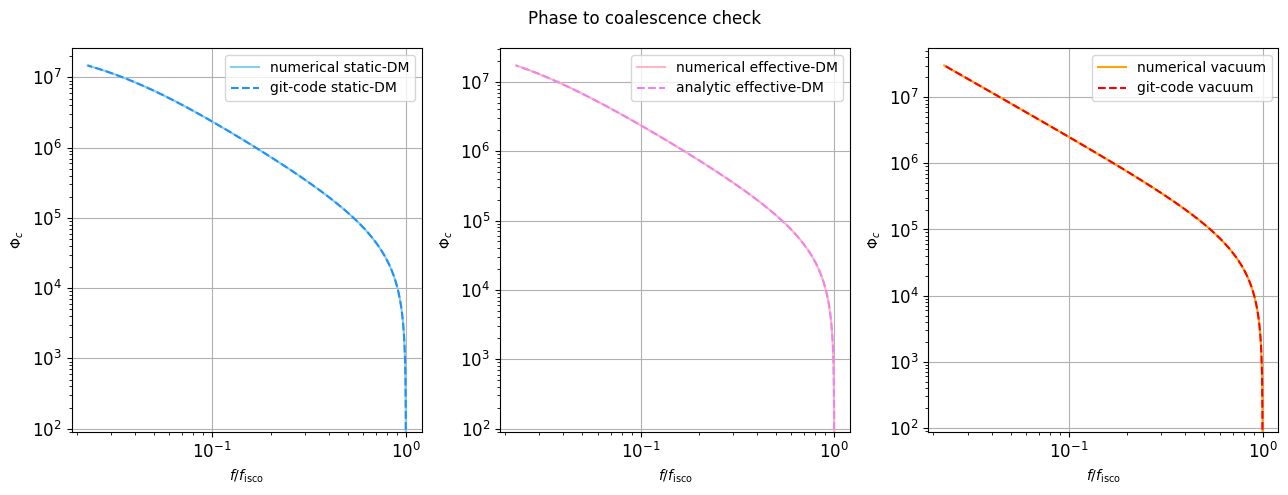

In [18]:
# Check if the analytical and numerical overlap
fig, ax = plt.subplots(1, 3, figsize=(13, 5))

ax[0].loglog(freqs/f_isco, -phase_dm_s, c='skyblue', linestyle='-', label='numerical static-DM')
ax[0].loglog(freqs/f_isco, phase_check_dm_s, linestyle='--', label='git-code static-DM', c='dodgerblue')
ax[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0].set_ylabel(r'$\Phi_c$', fontsize=10) 
ax[0].tick_params(axis='x', labelsize=12)  
ax[0].tick_params(axis='y', labelsize=12)  
ax[0].grid(True)
ax[0].legend()

ax[1].loglog(freqs/f_isco, -phase_dm_eff, c='lightpink', linestyle='-', label='numerical effective-DM')
ax[1].loglog(freqs/f_isco, phase_check_dm_eff, linestyle='--', label='analytic effective-DM', c='violet')
ax[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1].set_ylabel(r'$\Phi_c$', fontsize=10) 
ax[1].tick_params(axis='x', labelsize=12)  
ax[1].tick_params(axis='y', labelsize=12)  
ax[1].grid(True)
ax[1].legend()

ax[2].loglog(freqs/f_isco, -phase_gw, c='orange', linestyle='-', label='numerical vacuum')
ax[2].loglog(freqs/f_isco, phase_check_vacuum, linestyle='--', label='git-code vacuum', c='red')
ax[2].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[2].set_ylabel(r'$\Phi_c$', fontsize=10) 
ax[2].tick_params(axis='x', labelsize=12)  
ax[2].tick_params(axis='y', labelsize=12)  
ax[2].grid(True)
ax[2].legend()

plt.suptitle('Phase to coalescence check')
plt.tight_layout();

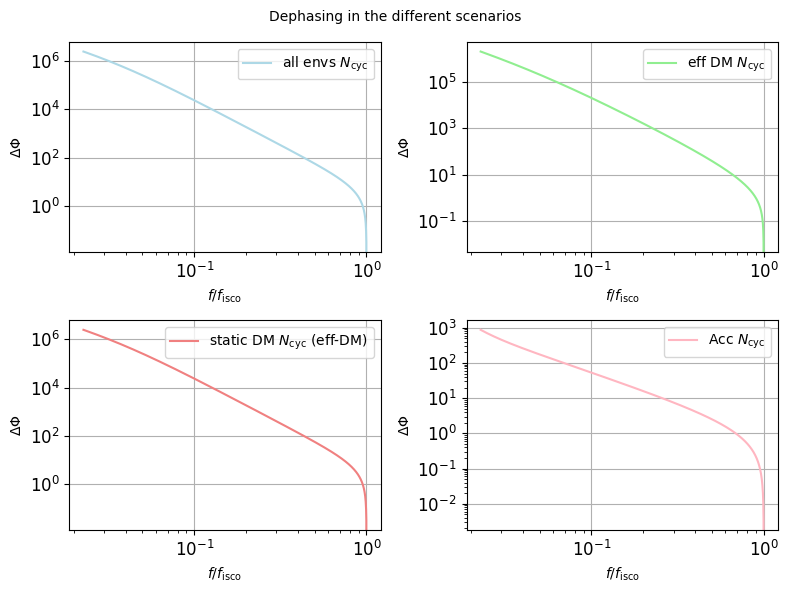

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].loglog(freqs/f_isco, N_all, c='lightblue', linestyle='-', label='all envs $N_{\mathrm{cyc}}$')
ax[0, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0, 0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[0, 0].tick_params(axis='x', labelsize=12)  
ax[0, 0].tick_params(axis='y', labelsize=12)  
ax[0, 0].grid(True)
ax[0, 0].legend()

ax[0, 1].loglog(freqs/f_isco, N_dm_eff, c='lightgreen', linestyle='-', label='eff DM $N_{\mathrm{cyc}}$')
ax[0, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0, 1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[0, 1].tick_params(axis='x', labelsize=12)  
ax[0, 1].tick_params(axis='y', labelsize=12)  
ax[0, 1].grid(True)
ax[0, 1].legend()

ax[1, 0].loglog(freqs/f_isco, N_dm_s, c='lightcoral', linestyle='-', label='static DM $N_{\mathrm{cyc}}$ (eff-DM)')
ax[1, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1, 0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[1, 0].tick_params(axis='x', labelsize=12)  
ax[1, 0].tick_params(axis='y', labelsize=12)  
ax[1, 0].grid(True)
ax[1, 0].legend()

ax[1, 1].loglog(freqs/f_isco, N_acc, c='lightpink', linestyle='-', label='Acc $N_{\mathrm{cyc}}$')
ax[1, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1, 1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[1, 1].tick_params(axis='x', labelsize=12)  
ax[1, 1].tick_params(axis='y', labelsize=12)  
ax[1, 1].grid(True)
ax[1, 1].legend()

plt.suptitle('Dephasing in the different scenarios', fontsize=10)
plt.tight_layout()
plt.savefig('results-images/dephasing_effective_1e5.png');

---

- Set of parameters 2:

In [20]:
# Fix parameters:

m1_1 = 1.4e3 * m_sun 
m2_1 = 1.4 * m_sun 
q_1 = m2_1/m1_1
M_tot_1 = m1_1 + m2_1
mu_1 = m1_1 * m2_1 / M_tot_1
chirp_mass_1 = (m1_1 * m2_1)**(3/5) / (M_tot_1)**(1/5)

In [21]:
# New spike: 

rho6_1 = get_rho_6(226 * m_sun / (pc)**3, m1_1, 7/3)
r6 =  pc / 1e6
logL_1 = 1 / q_1**(1/2)

print('rho_6 val = ', rho6_1)

rho_6 val =  0.00047908573198146895


In [22]:
vacuum_binary_1 = VacuumBinary(
    m1=m1_1,
    m2=m2_1,
    dist=4e9 #pc
)

accretion_disk_1 = AccretionDisk(
    mach=Mach, 
    m1=m1_1,
    m2=m2_1, 
    dist=4e9,
    sigma0=sigma0, 
    alpha=alpha
)

dark_matter_1 = DarkMatter(
    m1=m1_1, 
    m2=m2_1, 
    dist=4e9, 
    q=q_1, 
    gammas=gammas, 
    rho6=rho6_1, 
    r6=r6, 
    epsv=epsv
)

### Define the domain

Defining the domain from the lower limit of LISA's sensitivity ($\sim 10^{-3}$), up to ISCO of the system.

In [23]:
# Build grid of vals

f_LISA = 1e-3 # Hz
r_max_1 = vacuum_binary_1.radius(f_LISA)

r_isco_1 = 6 * 1.4e3 * m_sun * G / c**2
f_isco_1 = vacuum_binary_1.frequency(r_isco_1)

print('isco frequency', f_isco_1)

# set grid of radial distances
r_grid_1 = np.linspace(r_isco_1, r_max_1, 10000 * 2)
freqs_1 = vacuum_binary_1.frequency(r_grid_1)

isco frequency 3.1407213111030896


### Dephasing

In [24]:
phase_gw_1 = vacuum_binary_1.vacuum_phase(r_grid_1)
phase_dm_s_1 = phase_f_by_hand(freqs_1, df_dt(vacuum_binary_1.df_dr(r_grid_1), dark_matter_1.dot_r_dm_s(r_grid_1) + vacuum_binary_1.dot_r_gw(r_grid_1)))
phase_dm_eff_1 = phase_f_by_hand(freqs_1, df_dt(vacuum_binary_1.df_dr(r_grid_1), dark_matter_1.dot_r_effDM(r_grid_1)))
phase_acc_1 = phase_f_by_hand(freqs_1, df_dt(vacuum_binary_1.df_dr(r_grid_1), accretion_disk_1.dot_r_acc(r_grid_1) + vacuum_binary_1.dot_r_gw(r_grid_1)))
phase_all_1 = phase_f_by_hand(freqs_1, df_dt(vacuum_binary_1.df_dr(r_grid_1), dark_matter_1.dot_r_dm_s(r_grid_1) + vacuum_binary_1.dot_r_gw(r_grid_1) + accretion_disk.dot_r_acc(r_grid_1)))

In [25]:
N_dm_s_1 = (phase_dm_s_1 - phase_gw_1)/(2 * np.pi)
N_acc_1 = (phase_acc_1 - phase_gw_1)/(2 * np.pi)
N_dm_eff_1 = (phase_dm_eff_1 - phase_gw_1)/(2 * np.pi)
N_all_1 = (phase_all_1 - phase_gw_1)/(2 * np.pi)

No check here, directly go to the results:

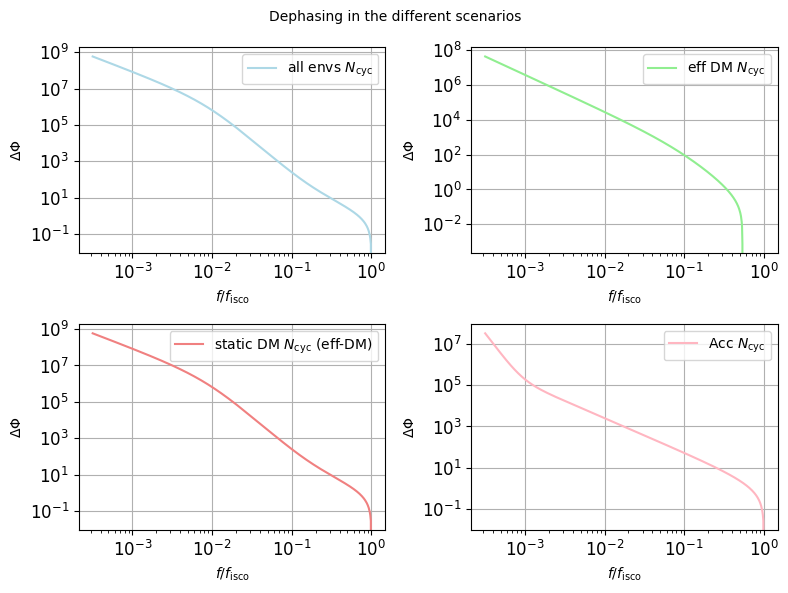

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].loglog(freqs_1/f_isco_1, N_all_1, c='lightblue', linestyle='-', label='all envs $N_{\mathrm{cyc}}$')
ax[0, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0, 0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[0, 0].tick_params(axis='x', labelsize=12)  
ax[0, 0].tick_params(axis='y', labelsize=12)  
ax[0, 0].grid(True)
ax[0, 0].legend()

ax[0, 1].loglog(freqs_1/f_isco_1, N_dm_eff_1, c='lightgreen', linestyle='-', label='eff DM $N_{\mathrm{cyc}}$')
ax[0, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[0, 1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[0, 1].tick_params(axis='x', labelsize=12)  
ax[0, 1].tick_params(axis='y', labelsize=12)  
ax[0, 1].grid(True)
ax[0, 1].legend()

ax[1, 0].loglog(freqs_1/f_isco_1, N_dm_s_1, c='lightcoral', linestyle='-', label='static DM $N_{\mathrm{cyc}}$ (eff-DM)')
ax[1, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1, 0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[1, 0].tick_params(axis='x', labelsize=12)  
ax[1, 0].tick_params(axis='y', labelsize=12)  
ax[1, 0].grid(True)
ax[1, 0].legend()

ax[1, 1].loglog(freqs_1/f_isco_1, N_acc_1, c='lightpink', linestyle='-', label='Acc $N_{\mathrm{cyc}}$')
ax[1, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
ax[1, 1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
ax[1, 1].tick_params(axis='x', labelsize=12)  
ax[1, 1].tick_params(axis='y', labelsize=12)  
ax[1, 1].grid(True)
ax[1, 1].legend()

plt.suptitle('Dephasing in the different scenarios', fontsize=10)
plt.tight_layout()
plt.savefig('results-images/dephasing_eff_1e3.png');

In [27]:
#solved negative values problem using larger grid!

--- 

# Test 2) Multiple model parameters

We now work using the same functions as in the previous section, only varying parameters one by one (see also more specific work in $\texttt{Phase_extraction_DM_vs_Acc.ipynb}$). More specifically we'll change:

### For the accretion disk:

- The $\alpha$ parameter $\rightarrow \ [-0.4, -0.7]$ ($\beta$-disk regime), possibly changing the upper threshold to match an $\alpha$-disk. Particularly, the scaling relations go as: 

$$\Sigma_\alpha = 5.14 \cdot 10^3 (\frac{\alpha}{0.1})^{-1} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{-1} (\frac{r}{10 M_1})^{3/2} \ \text{kg m}^{-2} ;$$

$$\Sigma_\beta = 2.1 \cdot 10^7 (\frac{\alpha}{0.1})^{-4/5} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{3/5} (\frac{M_1}{10^6 M_{\odot}})^{1/5} (\frac{r}{10 M_1})^{-3/5}.$$

- $\Sigma_0$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 

### For the dark matter spike:

- The $\gamma_s$ parameter $\rightarrow \ [2, 2.5]$;
- $\rho_m$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 


We look to see how changing just one of these parameters will affect the inspiral. If the dephasing $\Delta\Phi$ increases, this means that the environmental effect is more likely to be detected, while the opposite indicates that a vacuum model wil still be compatible with the phase measured. 

An interesting POV is to find as a threshold the values of densities normalizations such that $\Delta\Phi < 2\pi$ (MY IDEA: set the $\texttt{r_dot}$ such that the normalizations get out of the dephasing and then set $\Sigma = \Delta\Phi / \Delta\Phi_{\mathrm{fake}}$). In the $\texttt{Phase_extraction_CLASS}$ notebook I saw different plots varying just one parameter. In this one I will vary two parameters contemporarily and see how this affects the dephasing. 

## Density normalizations ($\Sigma_0 \text{ vs } \rho_6$)

Will use the first parameters configuration.

In [28]:
sigma_0_i = np.logspace(8, 11, 10)
rho_6_i = np.logspace(15, 18, 10)

In [29]:
# Define models based on params

accretion_disk_density = [AccretionDisk(
    mach=Mach, 
    m1=m1,
    m2=m2, 
    dist=4e9,
    sigma0=sigma / Mach**2, 
    alpha=alpha
)for sigma in sigma_0_i]

dark_matter_density = [DarkMatter(
    m1=m1, 
    m2=m2, 
    dist=4e9, 
    q=q, 
    gammas=gammas, 
    rho6=rho * m_sun / pc**3, 
    r6=r6, 
    epsv=epsv
)for rho in rho_6_i]

### Dephasing

I here report the graphs only for the effective DM profile (for the static see $\texttt{Phase_extraction-DM_vs_Acc.ipynb}$ notebook).

In [30]:
# Produce matrix of dot_r

dot_r_dense = np.array([[(accretion_disk_density[i].dot_r_acc(r_grid) + dark_matter_density[j].dot_r_effDM(r_grid)) for i in range(0, len(sigma_0_i))] for j in range(0, len(rho_6_i))])

In [31]:
# Find dephasing

phase_all_dense = [[phase_f_by_hand(freqs, df_dt(vacuum_binary.df_dr(r_grid), dot_r_dense[i][j])) for i in range(0, len(sigma_0_i))] for j in range(0, len(rho_6_i))]

In [32]:
N_all_dense = (np.array(phase_all_dense) - np.array(phase_gw)) / (2 * np.pi)
print(N_all_dense.shape)

(10, 10, 10000)


In [33]:
# select components to see on plot

n_comp_to_see = [100, 1000, 2000, 4000, 6000, 7000, 8000, 9000, 9999]

In [34]:
# very slight difference

N_all_dense[1, 6, 2000] - N_all_dense[8, 6, 2000]

-0.016327183883731777

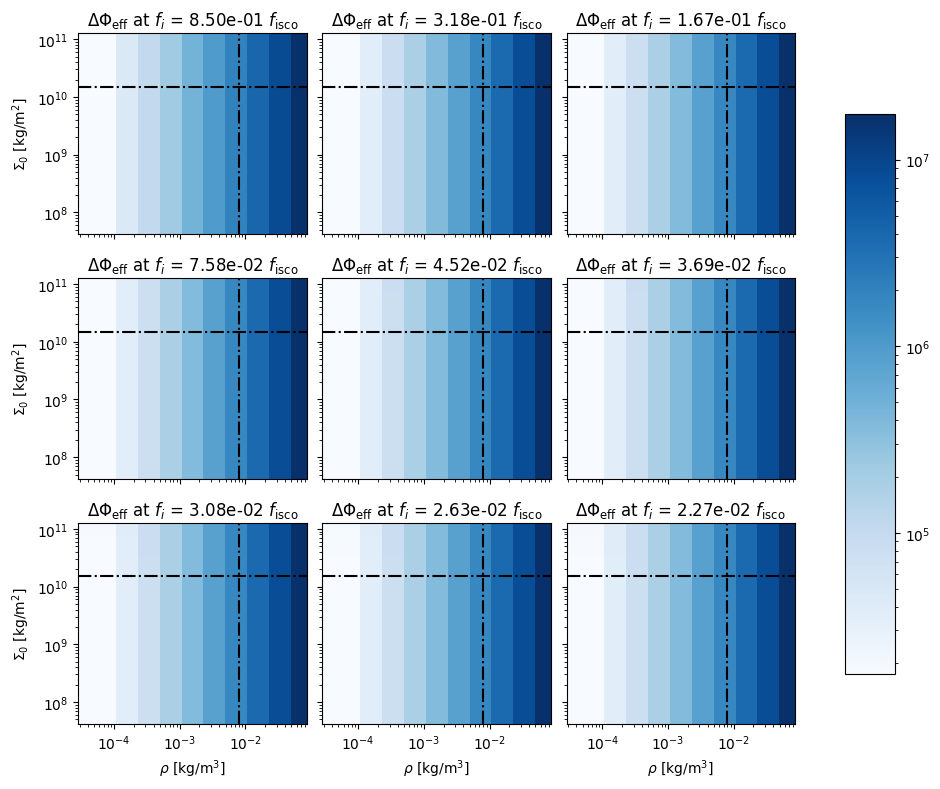

In [35]:
# Plot

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))

for ax, i in zip(axes.flat, n_comp_to_see):
    im = ax.pcolormesh(rho_6_i  * m_sun / (pc)**3, sigma_0_i, N_all_dense[:, :, i], cmap='Blues', norm=LogNorm()) 
    ax.axvline(x=1.17 * 1e17 * m_sun / (pc)**3, c='black', linestyle='-.', label='ref vals')
    ax.axhline(y=1.5 * 1e10, c='black', linestyle='-.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('$\Sigma_0$ [kg/m$^2$]')
    ax.set_xlabel(r'$\rho$ [kg/m$^3$]')
    ax.label_outer()
    ax.set_title(f'$\Delta\Phi_{{\mathrm{{eff}}}}$ at $f_i$ = {freqs[i]/f_isco:.2e} $f_{{\mathrm{{isco}}}}$')    
    
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('results-images/phi_DELTA_densities_eff.png')

plt.show()

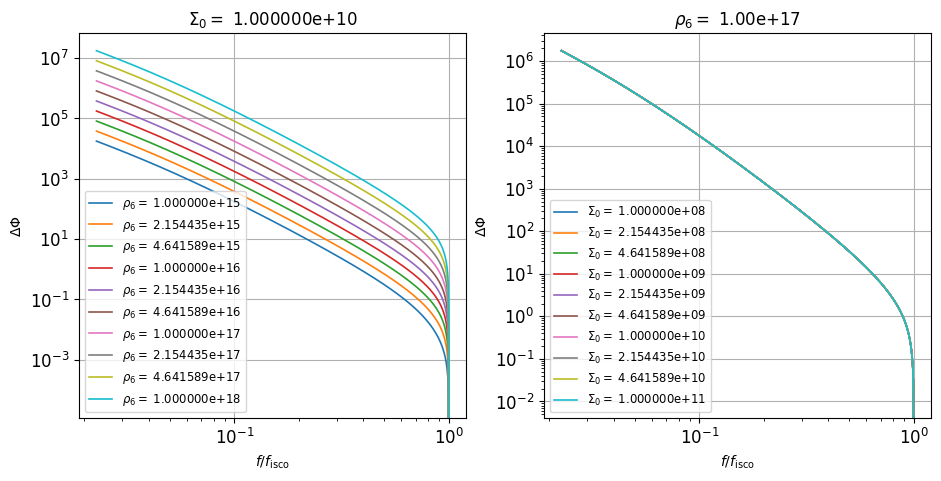

In [36]:
# Check multiple norm dephase

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

for i in range(0, 10):
    
    axes[0].loglog(freqs/f_isco, N_all_dense[6, i, :], linestyle='-', label=fr'$\rho_6 =$ {rho_6_i[i]:2e}', linewidth=1.2)
    
axes[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
axes[0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].tick_params(axis='y', labelsize=12)  
axes[0].grid(True)
axes[0].set_title(fr'$\Sigma_0 = $ {sigma_0_i[6]:2e}')
axes[0].legend(fontsize='small')

for i in range(0, 10):
    
    axes[1].loglog(freqs/f_isco, N_all_dense[i, 6, :], linestyle='-', label=fr'$\Sigma_0 =$ {sigma_0_i[i]:2e}', linewidth=1.2)
    
axes[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
axes[1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].tick_params(axis='y', labelsize=12)  
axes[1].grid(True)
axes[1].set_title(fr'$\rho_6 =$ {rho_6_i[6]:.2e}')
axes[1].legend(fontsize='small');

## Density slopes ($\gamma_s \text{ vs } \alpha$)

In [37]:
alpha_i = np.linspace(-0.7, 1.5, 10)
gamma_s_i = np.linspace(2, 2.5, 10)

In [38]:
# Define models based on params

accretion_disk_slope = [AccretionDisk(
    mach=Mach, 
    m1=m1,
    m2=m2, 
    dist=4e9,
    sigma0=sigma0, 
    alpha=alpha
)for alpha in alpha_i]

dark_matter_slope = [DarkMatter(
    m1=m1, 
    m2=m2, 
    dist=4e9, 
    q=q, 
    gammas=gamma, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv
)for gamma in gamma_s_i]

### Dephasing

I, again, report the graphs only for the effective DM profile (for the static see $\texttt{Phase_extraction-DM_vs_Acc.ipynb}$ notebook).

In [39]:
# Produce matrix of dot_r

dot_r_slope = np.array([[(accretion_disk_slope[i].dot_r_acc(r_grid) + dark_matter_slope[j].dot_r_effDM(r_grid)) for i in range(0, len(alpha_i))] for j in range(0, len(gamma_s_i))])

In [40]:
# Find dephasing

phase_all_slope = [[phase_f_by_hand(freqs, df_dt(vacuum_binary.df_dr(r_grid), dot_r_slope[i][j])) for i in range(0, len(alpha_i))] for j in range(0, len(gamma_s_i))]

In [41]:
N_all_slope = (np.array(phase_all_slope) - np.array(phase_gw))/(2 * np.pi)
print(N_all_slope.shape)

(10, 10, 10000)


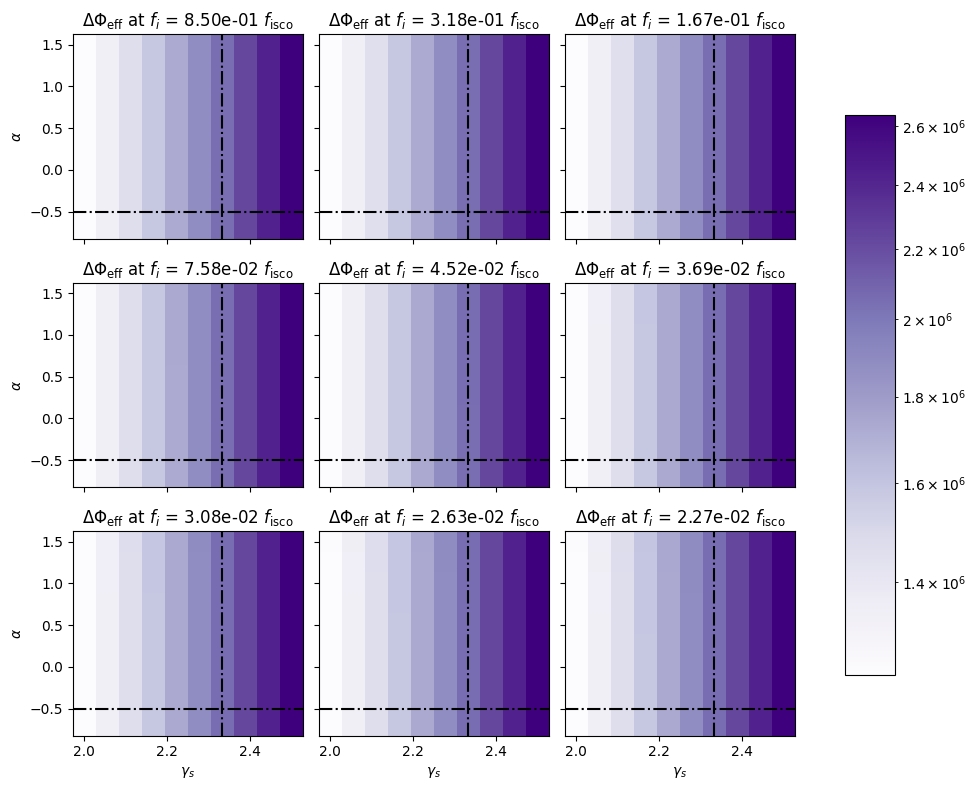

In [42]:
# Plot

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))

for ax, i in zip(axes.flat, n_comp_to_see):
    im = ax.pcolormesh(gamma_s_i, alpha_i, N_all_slope[:, :, i], cmap='Purples', norm=LogNorm()) 
    ax.axvline(x=7/3, c='black', linestyle='-.', label='ref vals')
    ax.axhline(y=-0.5, c='black', linestyle='-.')
    ax.set_ylabel(r'$\alpha$')
    ax.set_xlabel(r'$\gamma_s$')
    ax.label_outer()
    ax.set_title(f'$\Delta\Phi_{{\mathrm{{eff}}}}$ at $f_i$ = {freqs[i]/f_isco:.2e} $f_{{\mathrm{{isco}}}}$')
    
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('results-images/phi_DELTA_slopes_eff.png')

plt.show()

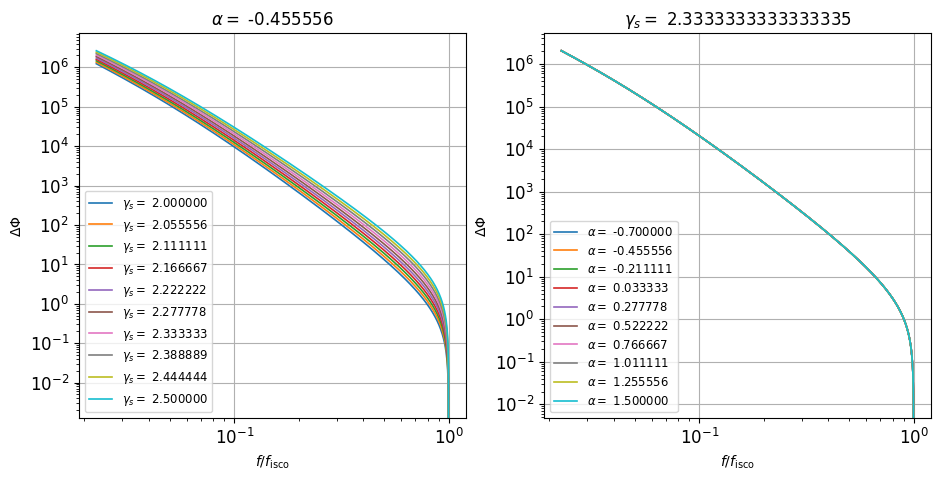

In [43]:
# Check multiple slope dephase

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

for i in range(0, 10):
    
    axes[0].loglog(freqs/f_isco, N_all_slope[1, i, :], linestyle='-', label=f'$\gamma_s =$ {gamma_s_i[i]:2f}', linewidth=1.2)
    
axes[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
axes[0].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].tick_params(axis='y', labelsize=12)  
axes[0].grid(True)
axes[0].set_title(fr'$\alpha = $ {alpha_i[1]:2f}')
axes[0].legend(fontsize='small')

for i in range(0, 10):
    
    axes[1].loglog(freqs/f_isco, N_all_slope[i, 6, :], linestyle='-', label=fr'$\alpha =$ {alpha_i[i]:2f}', linewidth=1.2)
    
axes[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
axes[1].set_ylabel(r'$\Delta\Phi$', fontsize=10) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].tick_params(axis='y', labelsize=12)  
axes[1].grid(True)
axes[1].set_title(fr'$\gamma_s =$ {gamma_s_i[6]}')
axes[1].legend(fontsize='small');

---

# Test 3) Benchmark value for $\rho_{\mathrm{dm}}$

We need to now use our models varying the parameter $\rho_{\mathrm{dm}}$ until we find a condition for which two phases with different environments are comparable. To do so, we need to build a function that, fixing the frequency at which we want to evaluate the minimum distance between dephases, returns the curve with the optimal parameters satisfying this condition. Indeed the dephasing should be minimal when accretion and dark matter have the same weight. 

I will test two conditions:

- $\Delta\Phi_{\mathrm{dm, static}} \simeq \Delta\Phi_{\mathrm{acc}}$

- $\Delta\Phi_{\mathrm{dm, efficient}} \simeq \Delta\Phi_{\mathrm{acc}}$

In [88]:
# Build grid of vals

f_LISA = 1e-3 # Hz
r_max_b = vacuum_binary.radius(f_LISA)

r_isco_b = 6 * 1e5 * m_sun * G / c**2
f_isco_b = vacuum_binary.frequency(r_isco_b)

print('isco frequency', f_isco_b)

# set grid of radial distances
r_grid_b = np.linspace(r_isco_b, r_max_b, 10000 * 5)
freqs_b = vacuum_binary.frequency(r_grid_b)

isco frequency 0.04397009835544326


In [89]:
# Find coalescence time by integration

def time_to_coal(freqs, df_dt):
    
    '''Finds the coalescence time (assuming all the environments) integrating over the frequency domain.'''
    
    to_integrate = (df_dt)**-1
    t_coal_f = []
    
    for f_low in freqs:
        f_range = freqs[freqs >= f_low]
        t_coal_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
    return np.array(t_coal_f)

In [90]:
# Find df_dt with which to work

df_dt_coal = df_dt(vacuum_binary.df_dr(r_grid_b), dark_matter.dot_r_dm_s(r_grid_b) + vacuum_binary.dot_r_gw(r_grid_b))

In [91]:
time_to_coal_data = -time_to_coal(freqs_b, df_dt_coal)
f_1yr = np.interp(3.156e7, time_to_coal_data, freqs_b) / f_isco

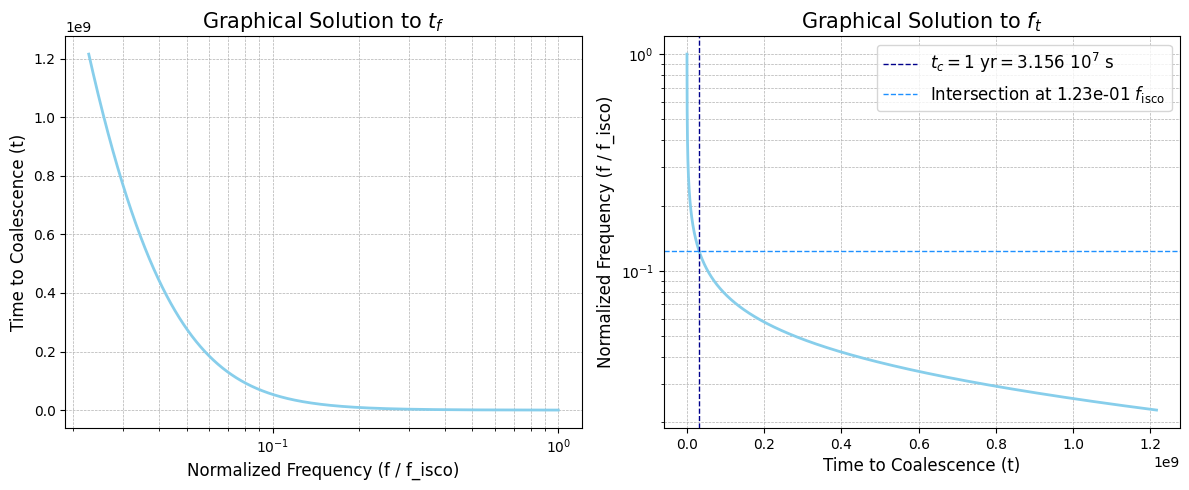

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[1].semilogy(time_to_coal_data, freqs_b / f_isco, c='skyblue', linewidth=2)
ax[1].set_xlabel('Time to Coalescence (t)', fontsize=12)
ax[1].set_ylabel('Normalized Frequency (f / f_isco)', fontsize=12)

ax[0].semilogx(freqs_b / f_isco, time_to_coal_data, c='skyblue', linewidth=2)
ax[0].set_ylabel('Time to Coalescence (t)', fontsize=12)
ax[0].set_xlabel('Normalized Frequency (f / f_isco)', fontsize=12)
ax[0].grid(True, which="both", linestyle='--', linewidth=0.5)

ax[1].axvline(3.156e7, c='darkblue', linestyle='--', label=f'$t_c = 1 \ \mathrm{{yr}} = 3.156 \ 10^7 \ \mathrm{{s}}$', linewidth=1)
ax[1].axhline(f_1yr, c='dodgerblue', linestyle='--', label=f'Intersection at {f_1yr:.2e} $f_{{\mathrm{{isco}}}}$', linewidth=1)
ax[1].grid(True, which="both", linestyle='--', linewidth=0.5)

ax[1].set_title('Graphical Solution to $f_t$', fontsize=15)
ax[0].set_title('Graphical Solution to $t_f$', fontsize=15)

plt.legend(fontsize='large')

plt.tight_layout()
plt.show()

In [93]:
# Increase rho_s_i grid size

rho_6_i_LARGE = np.logspace(9, 18, 100)

In [94]:
dark_matter_bench = [DarkMatter(
    m1=m1, 
    m2=m2, 
    dist=4e9, 
    q=q, 
    gammas=7/3, 
    rho6=rho * m_sun / pc**3, 
    r6=r6, 
    epsv=epsv
)for rho in rho_6_i_LARGE]

### Dephasing

In [95]:
phase_dm_s_bench = [phase_f_by_hand(freqs_b, df_dt(vacuum_binary.df_dr(r_grid_b), dark_matter_bench[i].dot_r_dm_s(r_grid_b) + vacuum_binary.dot_r_gw(r_grid_b))) for i in range(0, len(rho_6_i_LARGE))]
phase_dm_eff_bench = [phase_f_by_hand(freqs_b, df_dt(vacuum_binary.df_dr(r_grid_b), dark_matter_bench[i].dot_r_effDM(r_grid_b))) for i in range(0, len(rho_6_i_LARGE))]

In [96]:
phase_gw_bench = vacuum_binary.vacuum_phase(r_grid_b)
phase_acc_bench = phase_f_by_hand(freqs_b, df_dt(vacuum_binary.df_dr(r_grid_b), accretion_disk.dot_r_acc(r_grid_b) + vacuum_binary.dot_r_gw(r_grid_b)))

In [97]:
N_dm_s_bench = [np.array(phase_dm_s_bench[i]) - np.array(phase_gw_bench) for i in range(0, len(phase_dm_s_bench))]
N_dm_eff_bench = [np.array(phase_dm_eff_bench[i]) - np.array(phase_gw_bench) for i in range(0, len(phase_dm_s_bench))]
N_acc_bench = np.array(phase_acc_bench) - np.array(phase_gw_bench)

In [142]:
def find_dm_benchmark_1(N_cycles_1, N_cycles_2, rho_dm, f_ref):
    
    '''Finds the benchmark value for dark matter fixing the reference frequency, using two dephasings with same dimensions.'''
    
    i = np.where(freqs_b/f_isco < f_ref)[0][0]
    delta_N_cycles = np.array([np.abs(N_cycles_1[j][i] - N_cycles_2[j][i]) for j in range(0, len(N_cycles_1))]) 
    
    print(delta_N_cycles)
    
    i_min = np.where(delta_N_cycles == np.min(delta_N_cycles))[0][0]
    
    return rho_dm[i_min]

def find_dm_benchmark_2(N_cycles_array, N_cycles, rho_dm, f_ref):
    
    '''Finds the benchmark value for dark matter fixing the reference frequency, using two dephasings with different dimensions.'''
    
    i = np.where(freqs_b/f_isco < f_ref)[0][0]
    delta_N_cycles = np.array([np.abs(N_cycles_array[j][i] - N_cycles[i]) for j in range(0, len(N_cycles_array))])     
    i_min = np.where(delta_N_cycles == np.min(delta_N_cycles))[0][0]
    
    return rho_dm[i_min], i_min

def find_dm_benchmark_3(N_cycles_array, N_cycles, rho_dm, f_ref):
    
    '''Finds the benchmark value for dark matter fixing the reference frequency, using two dephasings with different dimensions.'''
    
    i = np.where(freqs_b/f_isco < f_ref)[0][0]
    delta_N_cycles = np.array([np.abs(N_cycles_array[j][i] - N_cycles[i]) for j in range(0, len(N_cycles_array))])     
    i_min = np.where(delta_N_cycles == np.min(delta_N_cycles))[0][0]
    
    return rho_dm[i_min]

In [99]:
rho_optimal_static, i_min_static = find_dm_benchmark_2(N_dm_s_bench, N_acc_bench, rho_6_i_LARGE, f_1yr)
print('rho benchmark = ', f'{rho_optimal_static:.7e}')

rho benchmark =  2.8480359e+11


In [100]:
rho_optimal_effect, i_min_effect = find_dm_benchmark_2(N_dm_eff_bench, N_acc_bench, rho_6_i_LARGE, f_1yr)
print('rho benchmark = ', f'{rho_optimal_effect:.7e}')

rho benchmark =  4.3287613e+14


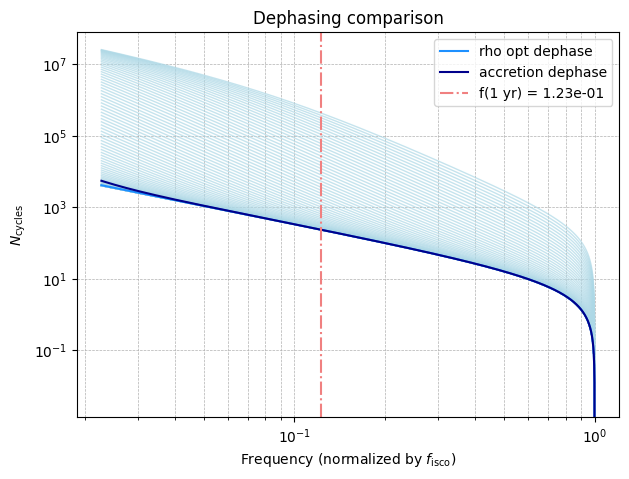

In [101]:
plt.figure(figsize=(7, 5))

for i in range(0, len(N_dm_s_bench)):
    plt.loglog(freqs_b / f_isco, N_dm_s_bench[i], c='lightblue', linewidth=1, alpha=0.7)

plt.loglog(freqs_b / f_isco, N_dm_s_bench[i_min_static], c='dodgerblue', linewidth=1.5, label='rho opt dephase')
plt.loglog(freqs_b / f_isco, N_acc_bench, c='darkblue', linewidth=1.5, label='accretion dephase')

plt.axvline(x=f_1yr, c='lightcoral', linestyle='-.', label=f'f(1 yr) = {f_1yr:.2e}')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.title('Dephasing comparison')
plt.xlabel('Frequency (normalized by $f_{\mathrm{isco}}$)')
plt.ylabel('$N_{\mathrm{cycles}}$')

plt.legend(fontsize='medium')
#plt.xlim(1e-2, 1.1)

plt.savefig('results-images/dephasing_comparison_static.png')
plt.show()

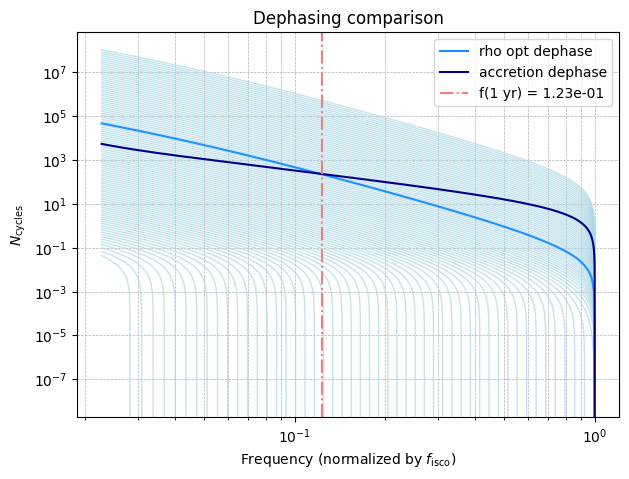

In [113]:
plt.figure(figsize=(7, 5))

for i in range(0, len(N_dm_s_bench)):
    plt.loglog(freqs_b / f_isco, N_dm_eff_bench[i], c='lightblue', linewidth=1, alpha=0.7)

plt.loglog(freqs_b / f_isco, N_dm_eff_bench[i_min_effect], c='dodgerblue', linewidth=1.5, label='rho opt dephase')
plt.loglog(freqs_b / f_isco, N_acc_bench, c='darkblue', linewidth=1.5, label='accretion dephase')

plt.axvline(x=f_1yr, c='lightcoral', linestyle='-.', label=f'f(1 yr) = {f_1yr:.2e}')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.title('Dephasing comparison')
plt.xlabel('Frequency (normalized by $f_{\mathrm{isco}}$)')
plt.ylabel('$N_{\mathrm{cycles}}$')

plt.legend(fontsize='medium')
#plt.xlim(1e-2, 1.1)

plt.savefig('results-images/dephasing_comparison_effect.png')
plt.show()

## Benchmark intervals 

In [116]:
rho_optimal_static_min = find_dm_benchmark_3(N_dm_s_bench, N_acc_bench, rho_6_i_LARGE, f_1yr)
rho_optimal_static_max = find_dm_benchmark_3(N_dm_s_bench, N_acc_bench, rho_6_i_LARGE, f_isco)

print('rho benchmark = [', f'{rho_optimal_static_min:.7e}, {rho_optimal_static_max:.7e}] M_sun / pc^3')

rho benchmark = [ 2.8480359e+11, 1.5199111e+12] M_sun / pc^3


In [118]:
rho_optimal_eff_max = find_dm_benchmark_3(N_dm_eff_bench, N_acc_bench, rho_6_i_LARGE, f_1yr)
rho_optimal_eff_min = find_dm_benchmark_3(N_dm_eff_bench, N_acc_bench, rho_6_i_LARGE, f_isco)

print('rho benchmark = [', f'{rho_optimal_eff_min:.7e}, {rho_optimal_eff_max:.7e}] M_sun / pc^3')

rho benchmark = [ 8.1113083e+13, 4.3287613e+14] M_sun / pc^3


In [148]:
rho_optimal_f_stat = np.array([find_dm_benchmark_3(N_dm_s_bench, N_acc_bench, rho_6_i_LARGE, i) for i in freqs_b[:-1]/f_isco])
rho_optimal_f_eff = np.array([find_dm_benchmark_3(N_dm_eff_bench, N_acc_bench, rho_6_i_LARGE, i) for i in freqs_b[:-1]/f_isco])

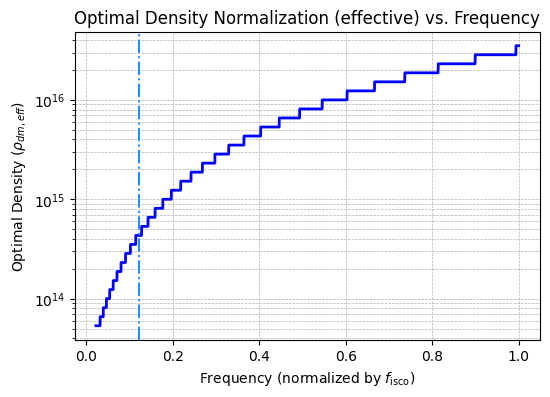

In [151]:
plt.figure(figsize=(6, 4))

plt.semilogy(freqs_b[:-1]/f_isco, rho_optimal_f_eff, c='blue', linewidth=2)

plt.xlabel('Frequency (normalized by $f_{\mathrm{isco}}$)')
plt.ylabel('Optimal Density ($\\rho_{dm, eff}$)')
plt.axvline(f_1yr, c='dodgerblue', linewidth=1.5, linestyle='-.')

plt.title('Optimal Density Normalization (effective) vs. Frequency')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.show()

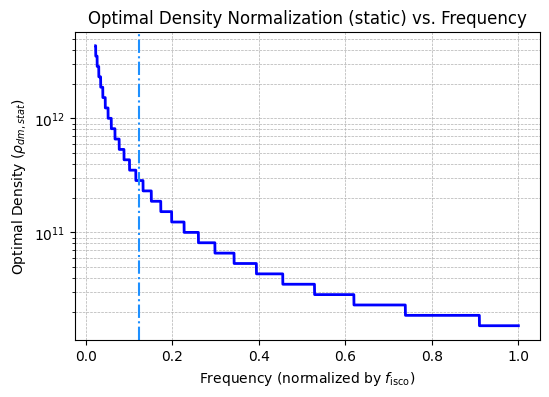

In [152]:
plt.figure(figsize=(6, 4))

plt.semilogy(freqs_b[:-1]/f_isco, rho_optimal_f_stat, c='blue', linewidth=2)

plt.xlabel('Frequency (normalized by $f_{\mathrm{isco}}$)')
plt.ylabel('Optimal Density ($\\rho_{dm, stat}$)')
plt.axvline(f_1yr, c='dodgerblue', linewidth=1.5, linestyle='-.')

plt.title('Optimal Density Normalization (static) vs. Frequency')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.show()